In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from IPython.display import display


%matplotlib inline

In [17]:
#read the data and drop redundant coloumn
data=pd.read_csv("final_dataset.csv")




In [10]:
display(data.head())


,Unnamed: 0,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTGS,ATGS,HTGC,...,HTLossStreak5,ATWinStreak3,ATWinStreak5,ATLossStreak3,ATLossStreak5,HTGD,ATGD,DiffPts,DiffFormPts,DiffLP
0,0,2000-08-19,Charlton,Man City,4,0,H,0,0,0,...,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0
1,1,2000-08-19,Chelsea,West Ham,4,2,H,0,0,0,...,0,0,0,0,0,0.0,0.0,0.0,0.0,-4.0
2,2,2000-08-19,Coventry,Middlesbrough,1,3,NH,0,0,0,...,0,0,0,0,0,0.0,0.0,0.0,0.0,2.0
3,3,2000-08-19,Derby,Southampton,2,2,NH,0,0,0,...,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0
4,4,2000-08-19,Leeds,Everton,2,0,H,0,0,0,...,0,0,0,0,0,0.0,0.0,0.0,0.0,-10.0


In [18]:
data = data[data.MW > 3]

data.drop(['Unnamed: 0','HomeTeam', 'AwayTeam', 'Date', 'MW', 'HTFormPtsStr', 'ATFormPtsStr', 'FTHG', 'FTAG',
           'HTGS', 'ATGS', 'HTGC', 'ATGC','HomeTeamLP', 'AwayTeamLP','DiffPts','HTFormPts','ATFormPts',
           'HM4','HM5','AM4','AM5','HTLossStreak5','ATLossStreak5','HTWinStreak5','ATWinStreak5',
           'HTWinStreak3','HTLossStreak3','ATWinStreak3','ATLossStreak3'],1, inplace=True)

In [20]:
display(data.head())

,FTR,HTP,ATP,HM1,HM2,HM3,AM1,AM2,AM3,HTGD,ATGD,DiffFormPts,DiffLP
30,H,1.25,1.00,D,D,W,D,W,L,0.50,0.25,0.25,-16.0
31,NH,0.75,0.25,L,L,W,D,L,L,-0.50,-0.75,0.50,-2.0
32,H,1.00,1.00,L,D,W,D,W,L,0.00,0.25,0.00,-3.0
33,NH,0.75,0.50,L,L,W,D,L,D,-0.25,-0.25,0.25,3.0
34,NH,1.00,1.50,D,L,W,W,W,L,0.00,0.75,-0.50,3.0


In [23]:
# Total number of matches
n_matches = data.shape[0]

# Calculate number of features.
n_features = data.shape[1] - 1

# Calculate matches won by home team.
n_homewins = len(data[data.FTR == 'H'])

# Calculate win rate for home team.
win_rate = (float(n_homewins) / (n_matches)) * 100

# Print the results
print ("Total number of matches: {}".format(n_matches))
print ("Number of features: {}".format(n_features))
print ("Number of matches won by home team: {}".format(n_homewins))
print ("Win rate of home team: {:.2f}%".format(win_rate))

Total number of matches: 5600
Number of features: 12
Number of matches won by home team: 2603
Win rate of home team: 46.48%


/home/dewaniadi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  """


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f453098dc18>,
      dtype=object)

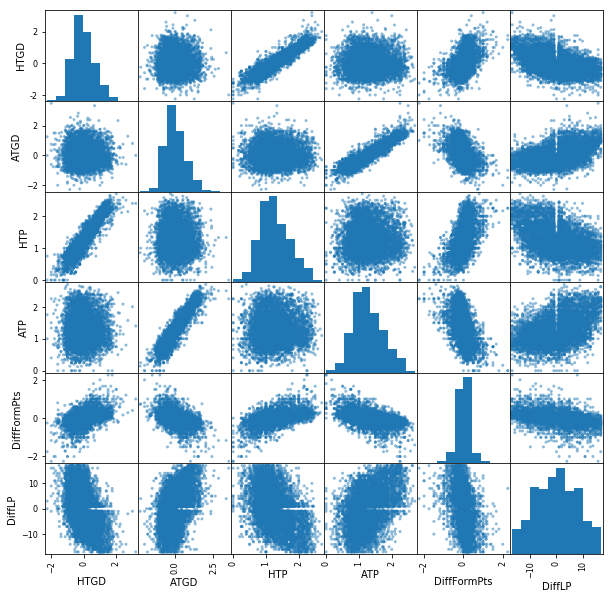

In [25]:
# Visualising distribution of data
from pandas.tools.plotting import scatter_matrix


scatter_matrix(data[['HTGD','ATGD','HTP','ATP','DiffFormPts','DiffLP']], figsize=(10,10))

In [27]:
# Separate into feature set and target variable
X_all = data.drop(['FTR'],1)
y_all = data['FTR']

# Standardising the data.
from sklearn.preprocessing import scale


cols = [['HTGD','ATGD','HTP','ATP','DiffLP']]
for col in cols:
    X_all[col] = scale(X_all[col])
    

In [29]:
display(X_all.head())

,HTP,ATP,HM1,HM2,HM3,AM1,AM2,AM3,HTGD,ATGD,DiffFormPts,DiffLP
30,-0.043829,-0.611968,D,D,W,D,W,L,0.753719,0.355995,0.25,-1.989216
31,-1.120644,-2.238746,L,L,W,D,L,L,-0.737082,-1.138834,0.50,-0.248963
32,-0.582236,-0.611968,L,D,W,D,W,L,0.008318,0.355995,0.00,-0.373267
33,-1.120644,-1.696487,L,L,W,D,L,D,-0.364382,-0.391419,0.25,0.372556
34,-0.582236,0.472551,D,L,W,W,W,L,0.008318,1.103409,-0.50,0.372556


In [30]:
display(y_all.head())

30     H
31    NH
32     H
33    NH
34    NH
Name: FTR, dtype: object

In [32]:
X_all.HM1 = X_all.HM1.astype('str')
X_all.HM2 = X_all.HM2.astype('str')
X_all.HM3 = X_all.HM3.astype('str')
X_all.AM1 = X_all.AM1.astype('str')
X_all.AM2 = X_all.AM2.astype('str')
X_all.AM3 = X_all.AM3.astype('str')

In [35]:
def preprocess_features(X):
    ''' Preprocesses the football data and converts catagorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix = col)
                    
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

X_all = preprocess_features(X_all)
print ("Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(X_all.columns)))

Processed feature columns (24 total features):
['HTP', 'ATP', 'HM1_D', 'HM1_L', 'HM1_W', 'HM2_D', 'HM2_L', 'HM2_W', 'HM3_D', 'HM3_L', 'HM3_W', 'AM1_D', 'AM1_L', 'AM1_W', 'AM2_D', 'AM2_L', 'AM2_W', 'AM3_D', 'AM3_L', 'AM3_W', 'HTGD', 'ATGD', 'DiffFormPts', 'DiffLP']


In [37]:
display(X_all.head())

,HTP,ATP,HM1_D,HM1_L,HM1_W,HM2_D,HM2_L,HM2_W,HM3_D,HM3_L,...,AM2_D,AM2_L,AM2_W,AM3_D,AM3_L,AM3_W,HTGD,ATGD,DiffFormPts,DiffLP
30,-0.043829,-0.611968,1,0,0,1,0,0,0,0,...,0,0,1,0,1,0,0.753719,0.355995,0.25,-1.989216
31,-1.120644,-2.238746,0,1,0,0,1,0,0,0,...,0,1,0,0,1,0,-0.737082,-1.138834,0.50,-0.248963
32,-0.582236,-0.611968,0,1,0,1,0,0,0,0,...,0,0,1,0,1,0,0.008318,0.355995,0.00,-0.373267
33,-1.120644,-1.696487,0,1,0,0,1,0,0,0,...,0,1,0,1,0,0,-0.364382,-0.391419,0.25,0.372556
34,-0.582236,0.472551,1,0,0,0,1,0,0,0,...,0,0,1,0,1,0,0.008318,1.103409,-0.50,0.372556


In [39]:
from sklearn.cross_validation import train_test_split

# Shuffle and split the dataset into training and testing set.
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, 
                                                    test_size = 50,
                                                    random_state = 2,
                                                    stratify = y_all)

In [41]:
display(X_train.head())

,HTP,ATP,HM1_D,HM1_L,HM1_W,HM2_D,HM2_L,HM2_W,HM3_D,HM3_L,...,AM2_D,AM2_L,AM2_W,AM3_D,AM3_L,AM3_W,HTGD,ATGD,DiffFormPts,DiffLP
2025,1.074403,0.055428,0,0,1,0,0,1,1,0,...,0,1,0,0,0,1,1.040411,-0.017712,0.076923,-1.616304
1343,-0.992452,-0.611968,0,1,0,0,1,0,1,0,...,0,1,0,0,1,0,-1.624464,-0.515989,0.095238,0.621164
4059,1.737058,1.056523,0,1,0,0,0,1,0,0,...,0,1,0,0,0,1,1.785812,0.959676,0.076923,-0.373267
82,-0.103652,-1.093976,0,0,1,1,0,0,0,0,...,0,0,1,1,0,0,0.173963,-0.183804,0.111111,1.118379
1697,0.255287,-0.250462,1,0,0,0,1,0,1,0,...,0,1,0,1,0,0,0.505252,-0.349896,0.000000,-0.124659


In [43]:
from time import time
from sklearn.metrics import f1_score

def train_classifier(clf,X_train,y_train):
    '''fitting classsifier to training data'''
    
    start=time()
    clf.fit(X_train,y_train)
    end=time()
    
    print("trained model in {:.4f} second " .format(end-start))
    

def prdict_labels(clf,features,target):
    ''' Makes prdiction using a fit classifier based on F1 score'''
    
    #start clock
    start=time()
    y_pred=clf.predict(features)
    end=time()
    print(" Made predictions in  {:.4f} second " .format(end-start))
    
    return f1_score(target,y_pred,pos_label='H') , sum(target==y_pred)/float(len(y_pred))

def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print ("Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    f1, acc = predict_labels(clf, X_train, y_train)
    print f1, acc
    print ("F1 score and accuracy score for training set: {:.4f} , {:.4f}.".format(f1 , acc))
    
    f1, acc = predict_labels(clf, X_test, y_test)
    print ("F1 score and accuracy score for test set: {:.4f} , {:.4f}.".format(f1 , acc))

    
    
    

SyntaxError: invalid syntax (<ipython-input-43-9ce685f5b99a>, line 32)